In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam, Adagrad, RMSprop, SGD
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Verify CUDA availability and print GPU name if available
if torch.cuda.is_available():
    print(f"CUDA is available. Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


Using device: cuda
CUDA is available. Device name: Tesla T4


In [ ]:
# Transforms
transformer = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 requires input size (224, 224)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Path for training, validation, and test directories
train_path = '/content/drive/MyDrive/TFR_data/CWT_Data/CWT_train'
val_path = '/content/drive/MyDrive/TFR_data/CWT_Data/CWT_validation'
test_path = '/content/drive/MyDrive/TFR_data/CWT_Data/CWT_test'

In [ ]:
# Counting data samples
train_count = len(glob.glob(os.path.join(train_path, '*/*.png')))
val_count = len(glob.glob(os.path.join(val_path, '*/*.png')))
test_count = len(glob.glob(os.path.join(test_path, '*/*.png')))
print(f"Number of samples in the training set: {train_count}")
print(f"Number of samples in the validation set: {val_count}")
print(f"Number of samples in the test set: {test_count}")

Number of samples in the training set: 800
Number of samples in the validation set: 100
Number of samples in the test set: 100


In [ ]:
# Define batch size
batch_size = 32

In [ ]:
# Create datasets and dataloaders for training, validation, and test
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transformer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform=transformer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transformer)


In [ ]:
# Categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['AF_train', 'NSR_train']


In [ ]:
# ResNet50 Network
class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Load the model
model = ResNet50(num_classes=2)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
# Define optimizers (Adam, AdaGrad, RMSprop, SGD)
optimizers = {
    "Adam": Adam(model.parameters(), lr=0.001)
}

criterion = nn.CrossEntropyLoss()

In [ ]:
# Dictionaries for storing losses and accuracies
train_losses = {key: [] for key in optimizers.keys()}
val_losses = {key: [] for key in optimizers.keys()}
train_accuracies = {key: [] for key in optimizers.keys()}
val_accuracies = {key: [] for key in optimizers.keys()}
best_accuracy = {key: 0 for key in optimizers.keys()}

In [ ]:
# Training loop for each optimizer
for opt_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {opt_name}")
    model.train()  # Reset to training mode

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_accuracy = 0

    for epoch in range(100):
        running_loss, running_corrects, num_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            num_samples += labels.size(0)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects.double() / num_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

Training with optimizer: Adam


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Assuming the necessary model, device, train_loader, val_loader and other required elements are defined.

# Initialize dictionaries to store the loss and accuracy data
train_losses_dict = {}
train_accuracies_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

# Training loop for each optimizer
for opt_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {opt_name}")
    model.train()  # Reset to training mode

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_accuracy[opt_name] = 0  # Initialize best accuracy to 0

    for epoch in range(100):
        running_loss, running_corrects, num_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            num_samples += labels.size(0)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects.double() / num_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase inside the epoch loop
        model.eval()  # Set model to evaluation mode
        val_loss, val_corrects, val_samples = 0.0, 0, 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_loss += loss.item() * images.size(0)
                val_samples += labels.size(0)

        val_loss /= val_samples
        val_losses.append(val_loss)
        val_acc = val_corrects.double() / val_samples
        val_accuracies.append(val_acc.item())

        print(f"Epoch {epoch+1}/5 - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if accuracy improves
        if val_acc > best_accuracy[opt_name]:
            best_accuracy[opt_name] = val_acc
            torch.save(model.state_dict(), f'resnet50_{opt_name}_best_model.pth')

    # Collecting loss and accuracy data in dictionaries for plotting
    train_losses_dict[opt_name] = train_losses
    train_accuracies_dict[opt_name] = train_accuracies
    val_losses_dict[opt_name] = val_losses
    val_accuracies_dict[opt_name] = val_accuracies




Training with optimizer: Adam
Epoch 1/5 - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.1870, Val Acc: 0.9600
Epoch 2/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2070, Val Acc: 0.9700
Epoch 3/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2610, Val Acc: 0.9700
Epoch 4/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2651, Val Acc: 0.9700
Epoch 5/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2699, Val Acc: 0.9700
Epoch 6/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2805, Val Acc: 0.9700
Epoch 7/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2806, Val Acc: 0.9700
Epoch 8/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2864, Val Acc: 0.9700
Epoch 9/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2854, Val Acc: 0.9700
Epoch 10/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2906, Val Acc: 0.9700
Epoch 11/5 - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.2915, Val Acc: 0.9700
Epoch 12/5 - Train Loss: 0.0000, 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


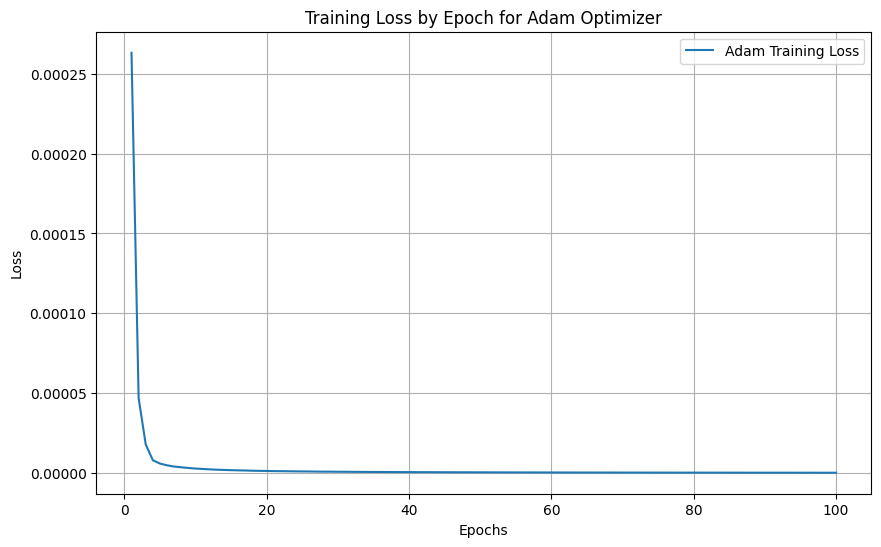

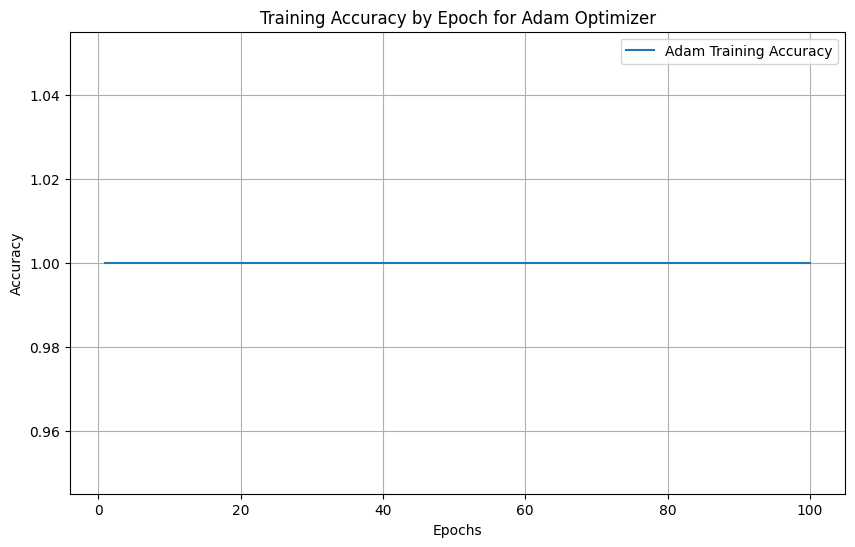

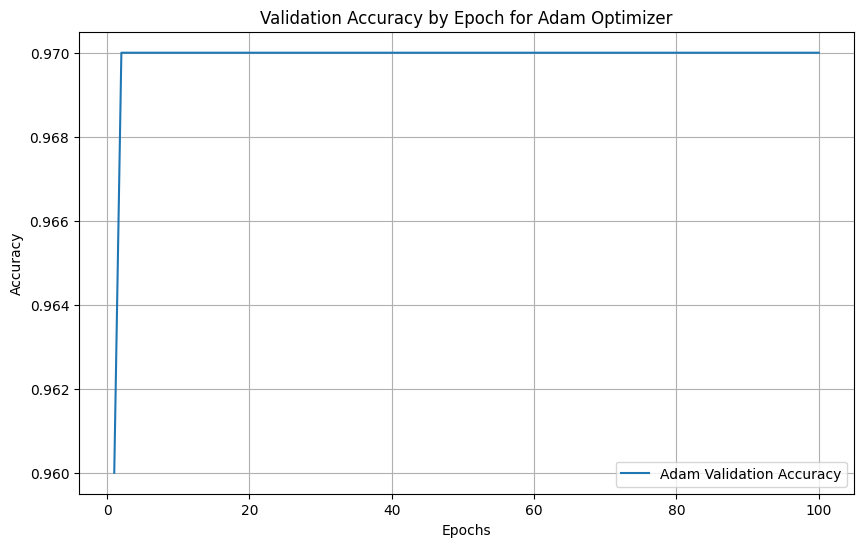

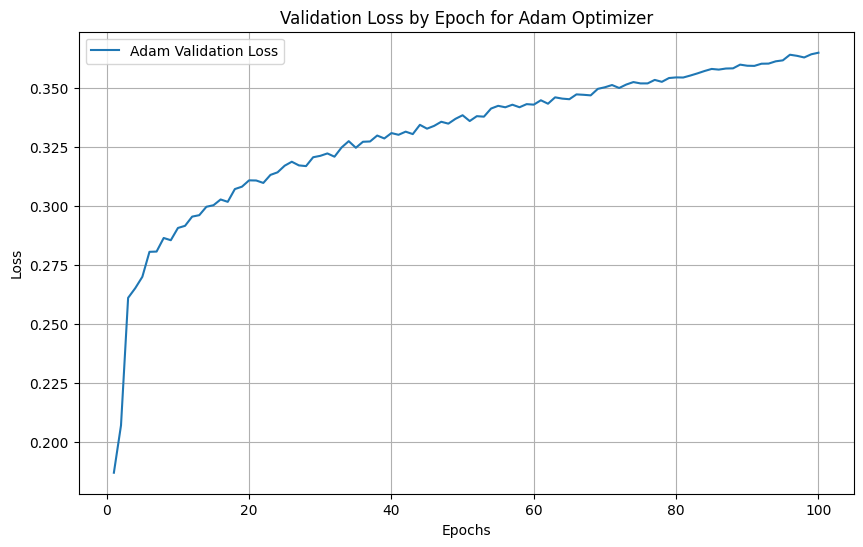

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create the "images" folder if it doesn't exist
images_folder = '/content/drive/My Drive/resnet_CWT_images'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Assuming train_losses_dict, train_accuracies_dict, val_accuracies_dict, and val_losses_dict are dictionaries containing the data

# Plot and save training loss
plt.figure(figsize=(10, 6))
for opt_name, losses in train_losses_dict.items():
    plt.plot(range(1, 101), losses, label=f'{opt_name} Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch for Adam Optimizer')
plt.legend()
plt.grid(True)
plt.savefig(f'{images_folder}/training_loss.jpg')  # Save the figure as JPEG

# Save training loss data to CSV
train_losses_df = pd.DataFrame(train_losses_dict)
train_losses_df.to_csv(f'{images_folder}/training_loss_data.csv', index_label='Epoch')

plt.show()

# Plot and save training accuracy
plt.figure(figsize=(10, 6))
for opt_name, accuracies in train_accuracies_dict.items():
    plt.plot(range(1, 101), accuracies, label=f'{opt_name} Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch for Adam Optimizer')
plt.legend()
plt.grid(True)
plt.savefig(f'{images_folder}/training_accuracy.jpg')  # Save the figure as JPEG

# Save training accuracy data to CSV
train_accuracies_df = pd.DataFrame(train_accuracies_dict)
train_accuracies_df.to_csv(f'{images_folder}/training_accuracy_data.csv', index_label='Epoch')

plt.show()

# Plot and save validation accuracy
plt.figure(figsize=(10, 6))
for opt_name, accuracies in val_accuracies_dict.items():
    plt.plot(range(1, 101), accuracies, label=f'{opt_name} Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Epoch for Adam Optimizer')
plt.legend()
plt.grid(True)
plt.savefig(f'{images_folder}/validation_accuracy.jpg')  # Save the figure as JPEG

# Save validation accuracy data to CSV
val_accuracies_df = pd.DataFrame(val_accuracies_dict)
val_accuracies_df.to_csv(f'{images_folder}/validation_accuracy_data.csv', index_label='Epoch')

plt.show()

# Plot and save validation loss
plt.figure(figsize=(10, 6))
for opt_name, losses in val_losses_dict.items():
    plt.plot(range(1, 101), losses, label=f'{opt_name} Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss by Epoch for Adam Optimizer')
plt.legend()
plt.grid(True)
plt.savefig(f'{images_folder}/validation_loss.jpg')  # Save the figure as JPEG

# Save validation loss data to CSV
val_losses_df = pd.DataFrame(val_losses_dict)
val_losses_df.to_csv(f'{images_folder}/validation_loss_data.csv', index_label='Epoch')

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


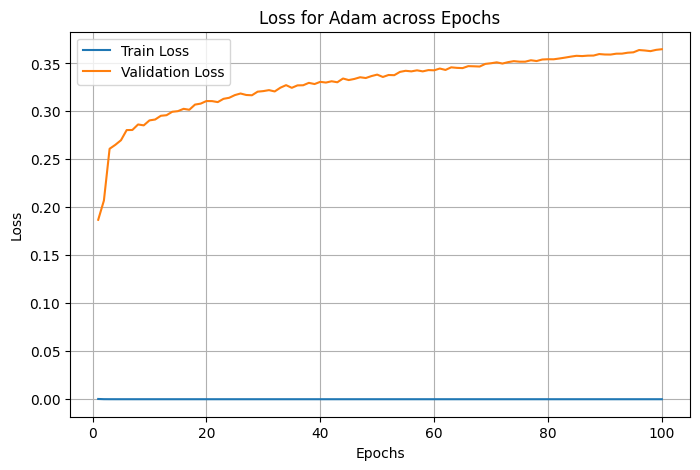

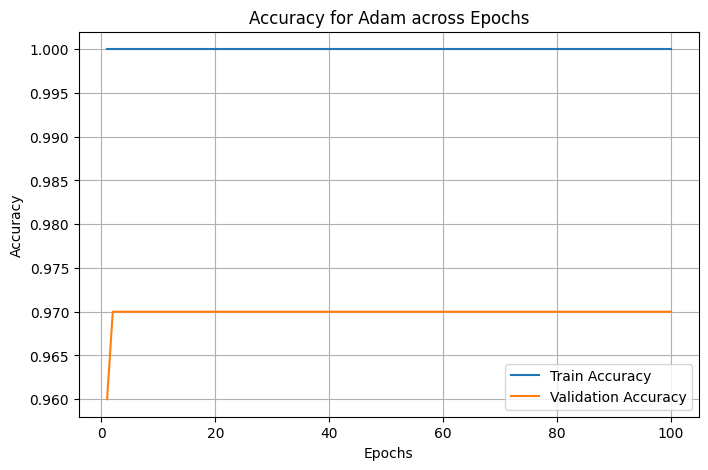

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create the "images" folder if it doesn't exist
images_folder = '/content/drive/My Drive/resnet_CWT_images'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Define a function to plot data for each optimizer and save the plots as JPEG
def plot_metrics(optimizer_name, train_data, val_data, metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 101), train_data[optimizer_name], label=f'Train {metric_name}')
    plt.plot(range(1, 101), val_data[optimizer_name], label=f'Validation {metric_name}')
    plt.title(f'{metric_name} for {optimizer_name} across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{images_folder}/{optimizer_name}_{metric_name.lower()}_plot.jpg')  # Save the figure as JPEG
    plt.show()

    # Save the data to CSV
    metrics_df = pd.DataFrame({
        'Epoch': range(1, 101),
        f'Train {metric_name}': train_data[optimizer_name],
        f'Validation {metric_name}': val_data[optimizer_name]
    })
    metrics_df.to_csv(f'{images_folder}/{optimizer_name}_{metric_name.lower()}_data.csv', index=False)

# Assuming train_losses_dict, train_accuracies_dict, val_accuracies_dict, and val_losses_dict are dictionaries containing the data
optimizers = train_losses_dict.keys()

# Loop through each optimizer to generate separate plots for each metric
for opt_name in optimizers:
    plot_metrics(opt_name, train_losses_dict, val_losses_dict, 'Loss', 'Loss')
    plot_metrics(opt_name, train_accuracies_dict, val_accuracies_dict, 'Accuracy', 'Accuracy')


In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Assuming transformer and batch_size are defined
test_path = '/content/drive/MyDrive/TFR_data/STFT_Data/STFT_test'

# Load the test dataset
test_dataset = ImageFolder(test_path, transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available
model = ResNet50(num_classes=2).to(device)  # Move model to the correct device
model.load_state_dict(torch.load('resnet50_Adam_best_model.pth', map_location=device))
model.eval()

# Initialize lists to store predictions
image_ids = [os.path.basename(path) for path, _ in test_dataset.imgs]  # Extract file paths
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move input data to the correct device
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Store predictions
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Print predictions for image ID, true labels, and predicted labels
print("Image ID\tTrue Label\tPredicted Label")
for i in range(len(image_ids)):
    print(f"{image_ids[i]}\t{true_labels[i]}\t{predicted_labels[i]}")

# Save predictions as a CSV file
predictions_data = {'Image ID': image_ids, 'True Label': true_labels, 'Predicted Label': predicted_labels}
predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved as predictions.csv")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image ID	True Label	Predicted Label
ecg_stft_image_JS01438_I.png	0	1
ecg_stft_image_JS01545_I.png	0	1
ecg_stft_image_JS01595_I.png	0	1
ecg_stft_image_JS01613_I.png	0	1
ecg_stft_image_JS01639_I.png	0	0
ecg_stft_image_JS01680_I.png	0	1
ecg_stft_image_JS01681_I.png	0	1
ecg_stft_image_JS01687_I.png	0	1
ecg_stft_image_JS01726_I.png	0	0
ecg_stft_image_JS01751_I.png	0	0
ecg_stft_image_JS01757_I.png	0	1
ecg_stft_image_JS01758_I.png	0	1
ecg_stft_image_JS01840_I.png	0	1
ecg_stft_image_JS01854_I.png	0	1
ecg_stft_image_JS01868_I.png	0	1
ecg_stft_image_JS01875_I.png	0	1
ecg_stft_image_JS01937_I.png	0	1
ecg_stft_image_JS02016_I.png	0	1
ecg_stft_image_JS02032_I.png	0	1
ecg_stft_image_JS02042_I.png	0	1
ecg_stft_image_JS02047_I.png	0	1
ecg_stft_image_JS02059_I.png	0	1
ecg_stft_image_JS02063_I.png	0	1
ecg_stft_image_JS02107_I.png	0	1
ecg_stft_image_JS02169_I.png	0	1
ecg_stft_image_JS02301_I.png	0	1
ecg_stft_image_JS02318_I.png	0	1
ecg_stft_image_JS02357_I.png	0	1
ecg_stft_image_JS02378_I.png	0	1
ecg_stf

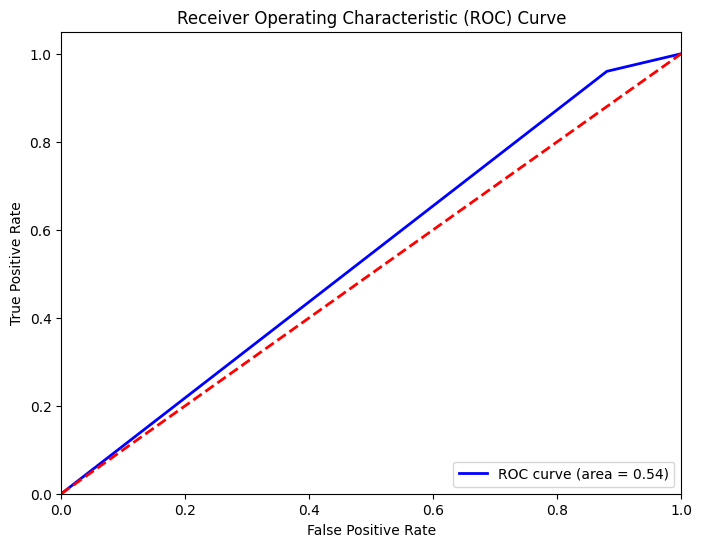

Overall Test Accuracy: 0.54
Confusion Matrix:
[[ 6 44]
 [ 2 48]]
Sensitivity (Recall): 0.96
Specificity: 0.12
F1-score: 0.6760563380281689


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate overall test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate sensitivity (recall) and specificity
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
sensitivity = recall_score(true_labels, predicted_labels)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print results
print("Overall Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1-score:", f1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


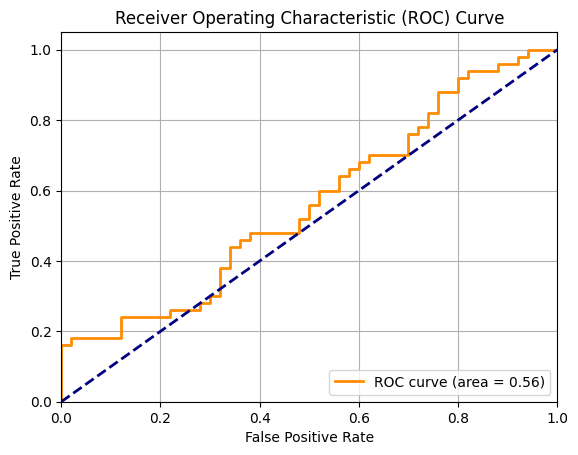

In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming transformer and batch_size are defined
test_path = '/content/drive/MyDrive/TFR_data/STFT_Data/STFT_test'

# Load the test dataset
test_dataset = ImageFolder(test_path, transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if GPU is available
model = ResNet50(num_classes=2).to(device)  # Move model to the correct device
model.load_state_dict(torch.load('resnet50_Adam_best_model.pth', map_location=device))
model.eval()

# Initialize lists to store predictions
true_labels = []
predicted_scores = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move input data to the correct device
        outputs = model(images)
        predicted_scores.extend(outputs[:, 1].cpu().numpy())  # Assuming 1 is the index for the positive class
        true_labels.extend(labels.cpu().numpy())

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.jpg')  # Save the ROC curve as a JPEG image
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


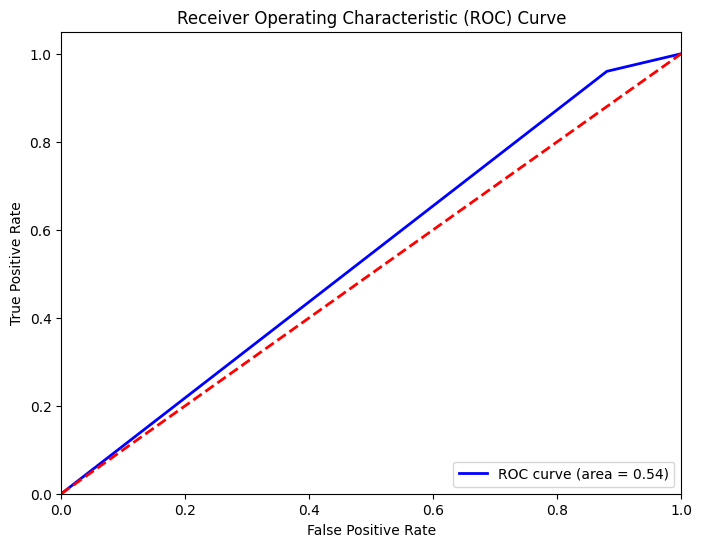

Overall Test Accuracy: 0.54
Confusion Matrix:
[[ 6 44]
 [ 2 48]]
Sensitivity (Recall): 0.96
Specificity: 0.12
F1-score: 0.6760563380281689


In [ ]:
from google.colab import drive
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create the "images" folder if it doesn't exist
images_folder = '/content/drive/My Drive/resnet_CWT_images'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Assuming true_labels and predicted_labels are already defined
# Calculate overall test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate sensitivity (recall) and specificity
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
sensitivity = recall_score(true_labels, predicted_labels)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the ROC curve plot in the "images" folder
plt.savefig(f'{images_folder}/roc_curve.jpg')
plt.show()

# Print results
print("Overall Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1-score:", f1)
